# Libreria

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

import yfinance as yf

plt.style.use('fivethirtyeight')

## Data

In [3]:
activos=['SAN','CIB','BBVA','REP.MC']
data=pd.DataFrame()
for i in activos:
  data[i]=yf.download(i,start='2022-01-01',end='2024-10-29')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


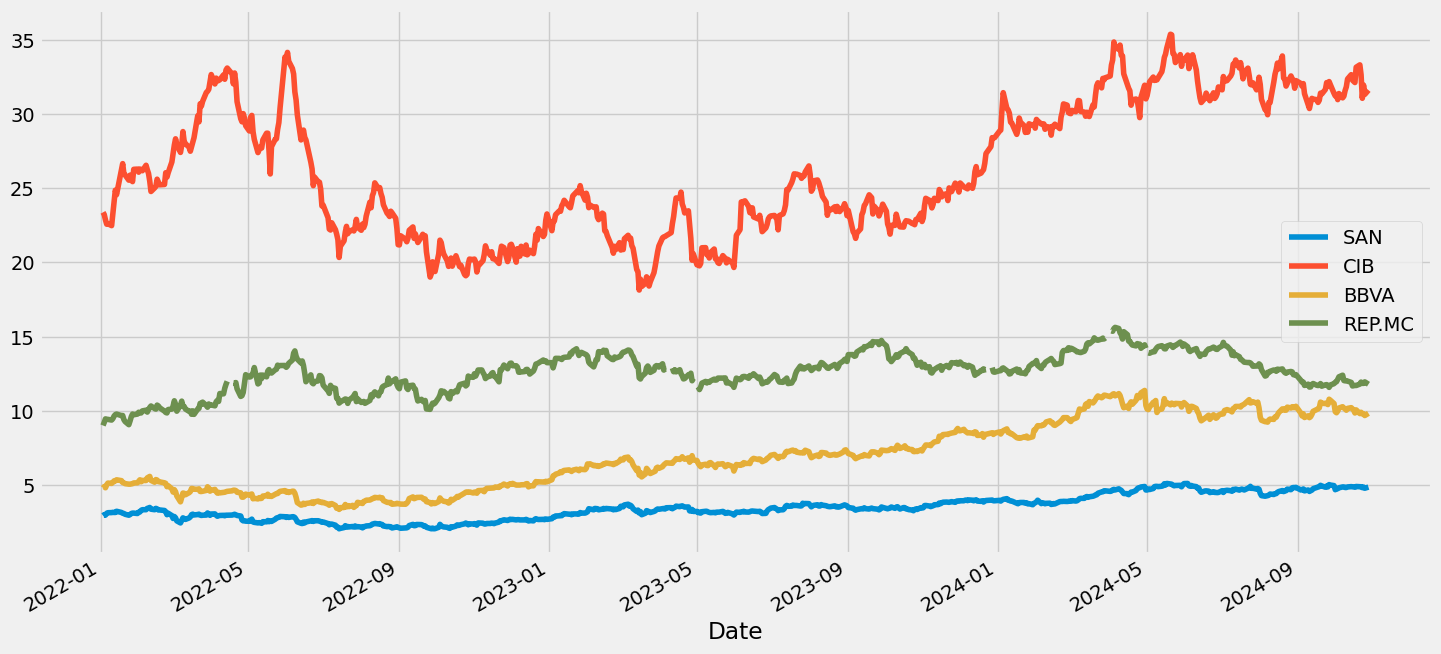

In [4]:
data.plot(figsize=(16,8))
plt.show()

## Portfolio

### Retorno Simple

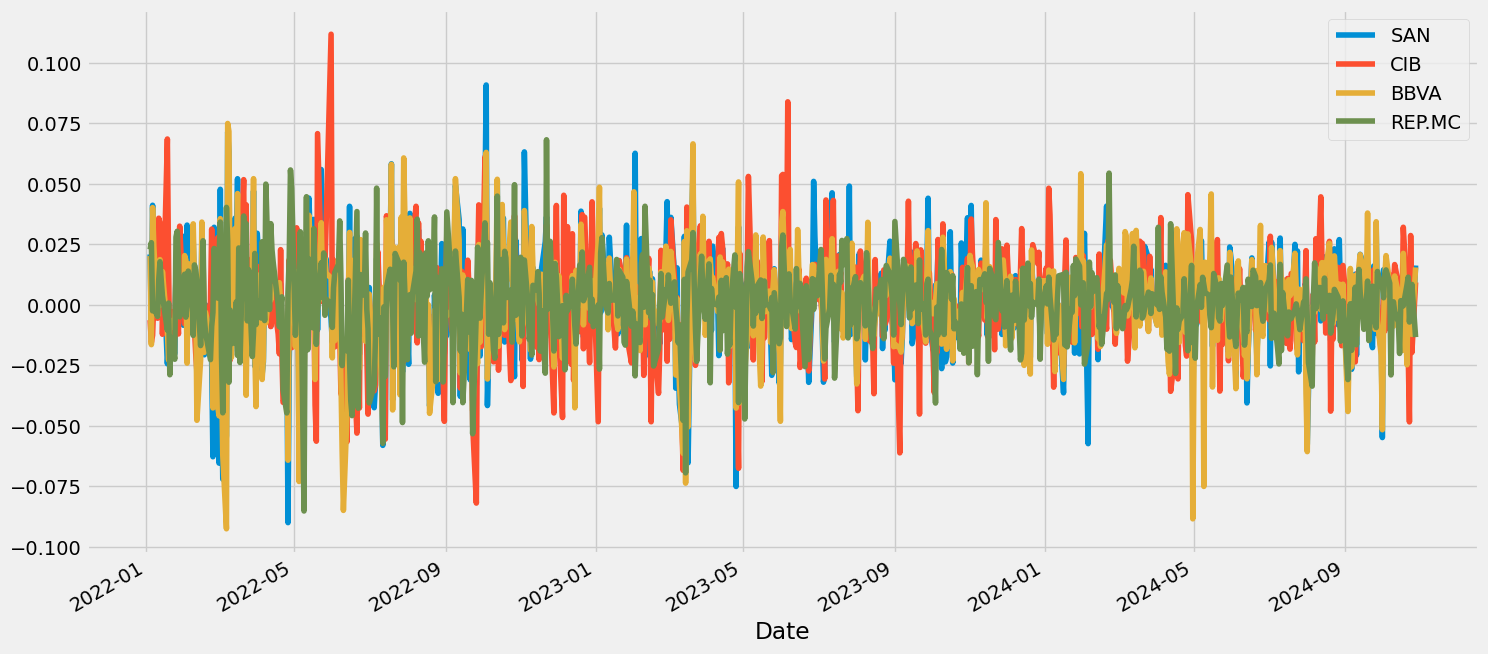

In [5]:
#Retorno simple
ret_simple=data.pct_change().dropna()
ret_simple.plot(figsize=(16,8))
plt.show()

### Retorno Logaritmico

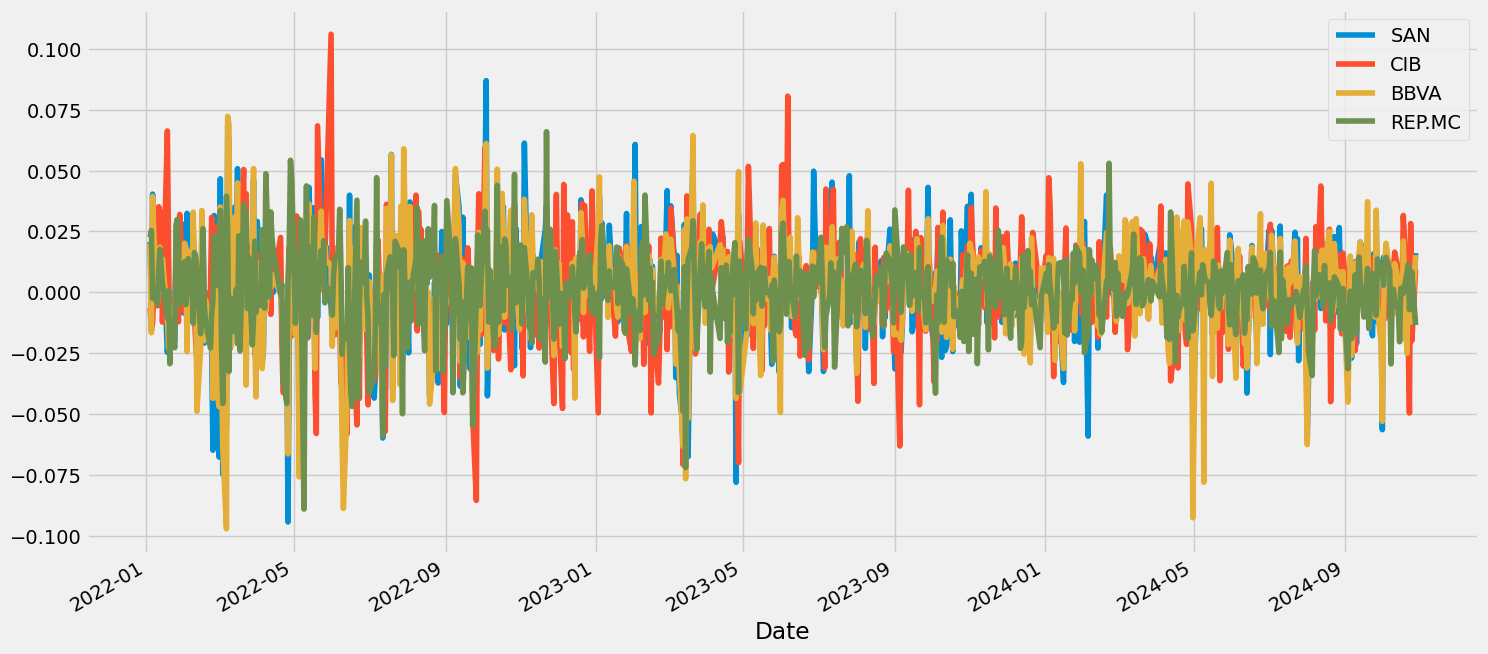

In [6]:
ret_log=np.log(data).diff().dropna()
ret_log.plot(figsize=(16,8))
plt.show()

# Rentabilidad

In [7]:
pesos= [0.25,0.25,0.25,0.25]
rentabilidad_portafolio=np.dot(ret_simple.mean()*252,pesos)

# Riesgos

In [8]:
riesgo_portafolio=np.sqrt(np.dot(np.transpose(pesos),np.dot(ret_log.cov()*252,pesos)))

In [9]:
print('Rentabilidad del portafolio:',rentabilidad_portafolio)
print('Riesgo del portafolio:',riesgo_portafolio)

Rentabilidad del portafolio: 0.2102909845290541
Riesgo del portafolio: 0.23892451817810986
